In [297]:
# bacend.ai
# !pip install prophet
# !pip install plotnine

# import

In [298]:
import numpy as np
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
# import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io

import statistics as st
%matplotlib inline
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error


# # var
# import sys
# sys.path.append("../Import")
# from definitions import crop_list3
# crop_list3 = [
#     ("마늘", "garlic"),
#     ("깻잎", "sesameLeaf"),
#     ("감자", "potato"),
#     ("고구마", "sweetPotato"),
# ]
root_path = "../"
data_path = f"{root_path}data/"


# var_param
# for non local ide
Product = "감자"
Product_eng = "potato"
# Product = crop_list3[3][0]
# Product_eng = crop_list3[3][1]
params_search = True
# for report file
model_name = "prophet"
freq = "MS"
test_year = (2019, 2020)

train_year1 = (2005, 2018)
train_year2 = (2010, 2018)

x0 = []
x1 = [
    "Food_Price_Index",
    "Cereals_Price_Index",
    "DayAvg_Temperature",
    "DayDiff_Temperature",
    "DayAvg_RelativeHumidity",
    "DaySum_Rainfall",
    "DayAvg_WindSpeed",
    "DaySum_Sunshine",
    "Warning_Count",
]
x2= [
    "Food_Price_Index",
    "Cereals_Price_Index",
]
x4 = [
    "DayAvg_Temperature",
    "DayDiff_Temperature",
    "DayAvg_RelativeHumidity",
    "DaySum_Rainfall",
    "DayAvg_WindSpeed",
    "DaySum_Sunshine",
    "Warning_Count",
]




train_year = train_year2
x = x1


y = "y"

# Data road

In [299]:
df_raw = pd.read_csv(f'{data_path}Agri_all.csv')
df_raw = df_raw[df_raw['Product'] == Product]
df_raw.head()

,YMD,YM,MD,Product,Price,KRW_USD_EXR,Annual_Call_Rate,item_PPI,item_CPI,Food_Price_Index,Cereals_Price_Index,DayAvg_Temperature,DayDiff_Temperature,DayAvg_RelativeHumidity,DaySum_Rainfall,DayAvg_WindSpeed,DaySum_Sunshine,Warning_Count
7940,2005-01-03,200501,103,감자,6323.101449,1013.0,3.33,71.15,69.162,65.4,60.5,4.50,6.75,47.75,1.0,3.75,0.25,0.0
7941,2005-01-04,200501,104,감자,6233.314286,1013.0,3.33,71.15,69.162,65.4,60.5,-2.25,8.00,36.25,0.0,3.00,3.50,0.0
7942,2005-01-05,200501,105,감자,6332.028169,1013.0,3.33,71.15,69.162,65.4,60.5,-3.50,11.50,44.75,0.0,0.50,4.25,0.0
7943,2005-01-06,200501,106,감자,6417.352113,1013.0,3.33,71.15,69.162,65.4,60.5,1.50,7.00,45.25,1.5,1.50,2.25,0.0
7944,2005-01-07,200501,107,감자,6581.362319,1013.0,3.33,71.15,69.162,65.4,60.5,0.25,9.25,38.75,0.0,3.00,4.00,0.0


# Data Pre-processing_1

## idx, col

In [300]:
# col
col_drop = ["YM", "MD"]
df_raw = df_raw.drop(columns=col_drop)
df_raw.rename(columns = {'YMD' : 'ds', "Price" : "y"}, inplace=True)    # "ds", "y" 필요함.

# idx
df_raw = df_raw.reset_index()
df_raw = df_raw.drop(columns='index')

df_raw.head()

,ds,Product,y,KRW_USD_EXR,Annual_Call_Rate,item_PPI,item_CPI,Food_Price_Index,Cereals_Price_Index,DayAvg_Temperature,DayDiff_Temperature,DayAvg_RelativeHumidity,DaySum_Rainfall,DayAvg_WindSpeed,DaySum_Sunshine,Warning_Count
0,2005-01-03,감자,6323.101449,1013.0,3.33,71.15,69.162,65.4,60.5,4.50,6.75,47.75,1.0,3.75,0.25,0.0
1,2005-01-04,감자,6233.314286,1013.0,3.33,71.15,69.162,65.4,60.5,-2.25,8.00,36.25,0.0,3.00,3.50,0.0
2,2005-01-05,감자,6332.028169,1013.0,3.33,71.15,69.162,65.4,60.5,-3.50,11.50,44.75,0.0,0.50,4.25,0.0
3,2005-01-06,감자,6417.352113,1013.0,3.33,71.15,69.162,65.4,60.5,1.50,7.00,45.25,1.5,1.50,2.25,0.0
4,2005-01-07,감자,6581.362319,1013.0,3.33,71.15,69.162,65.4,60.5,0.25,9.25,38.75,0.0,3.00,4.00,0.0


## date

In [301]:
if freq ==  "M" or freq ==  "MS":
    df_raw['ds'] = pd.to_datetime(df_raw['ds'])
    df_raw['ds'] = df_raw['ds'].dt.strftime('%Y-%m')
    df_raw = df_raw.reset_index()
    df_raw = df_raw.drop(columns='index')
    df_raw = df_raw.groupby('ds').mean()
    df_raw = df_raw.reset_index()
    df_raw = df_raw.rename(columns = {'index' : 'ds'})
    display(df_raw.head())

,ds,y,KRW_USD_EXR,Annual_Call_Rate,item_PPI,item_CPI,Food_Price_Index,Cereals_Price_Index,DayAvg_Temperature,DayDiff_Temperature,DayAvg_RelativeHumidity,DaySum_Rainfall,DayAvg_WindSpeed,DaySum_Sunshine,Warning_Count
0,2005-01,6467.292621,1013.0,3.33,71.15,69.162,65.4,60.5,-1.273810,9.154762,44.059524,0.309524,2.000000,3.166667,0.0
1,2005-02,7436.426577,1013.0,3.33,81.05,74.989,65.9,60.3,-0.470588,8.500000,45.235294,2.426471,2.382353,3.220588,0.0
2,2005-03,7081.545223,1013.0,3.33,84.32,70.888,67.1,61.5,4.886364,10.284091,43.511364,1.659091,2.306818,4.386364,0.0
3,2005-04,6834.099024,1013.0,3.33,93.61,66.735,65.6,59.5,12.857143,11.654762,39.619048,0.845238,2.583333,5.619048,0.0
4,2005-05,6803.346901,1013.0,3.33,83.21,66.195,66.3,59.4,16.250000,12.215909,44.102273,2.670455,1.795455,5.715909,0.0


# Data Pre-processing_2

In [302]:
df = df_raw.copy()

## Scaling - np.log()

In [303]:
df_inp = df.copy()

logsca_list = [y]

for i in logsca_list:
    df_inp[i] = np.log(df_inp[i])

display(df_inp.head())

,ds,y,KRW_USD_EXR,Annual_Call_Rate,item_PPI,item_CPI,Food_Price_Index,Cereals_Price_Index,DayAvg_Temperature,DayDiff_Temperature,DayAvg_RelativeHumidity,DaySum_Rainfall,DayAvg_WindSpeed,DaySum_Sunshine,Warning_Count
0,2005-01,8.774513,1013.0,3.33,71.15,69.162,65.4,60.5,-1.273810,9.154762,44.059524,0.309524,2.000000,3.166667,0.0
1,2005-02,8.914146,1013.0,3.33,81.05,74.989,65.9,60.3,-0.470588,8.500000,45.235294,2.426471,2.382353,3.220588,0.0
2,2005-03,8.865247,1013.0,3.33,84.32,70.888,67.1,61.5,4.886364,10.284091,43.511364,1.659091,2.306818,4.386364,0.0
3,2005-04,8.829680,1013.0,3.33,93.61,66.735,65.6,59.5,12.857143,11.654762,39.619048,0.845238,2.583333,5.619048,0.0
4,2005-05,8.825170,1013.0,3.33,83.21,66.195,66.3,59.4,16.250000,12.215909,44.102273,2.670455,1.795455,5.715909,0.0


## outlier

In [304]:
Q1 = df_inp[y].quantile(0.25)
Q3 = df_inp[y].quantile(0.75)
IQR = Q3 - Q1
LT = Q1 - 1.5 * IQR
HT = Q3 + 1.5 * IQR
print(LT, HT)

df_inp["outlier"] = np.where(((df_inp[y] < LT) | (df_inp[y] > HT)), "yes", "no")
print(df_inp['outlier'].value_counts())

# # outlier 시각화
# plt.boxplot(df_inp[df_inp.outlier=='no'][y])
# plt.show()
# plt.hist(df_inp[df_inp.outlier=='no'][y])
# plt.show()

7.28914709340964 9.901131370285917
no    192
Name: outlier, dtype: int64


## data split

In [305]:
if freq ==  "M" or freq ==  "MS":
    index_number = df_inp.index[(df_inp['ds'] == f'{train_year[1]}-12')][0] +1
    train = df_inp.iloc[:index_number]
    test = df_inp.iloc[index_number:]


elif freq == "D":
    index_number = df_inp.index[(df_inp['ds'] == f'{train_year[1]}-12-31')][0]
    train = df_inp.iloc[:index_number]
    test = df_inp.iloc[index_number:]
    print('Training data, last date: ' + str(train.tail(1)['ds']) + ' ' + 'testing data, last date: ' + str(test.tail(1)['ds']))
    
print(index_number)
display(train.tail(2))
display(test.head(2))

168


,ds,y,KRW_USD_EXR,Annual_Call_Rate,item_PPI,item_CPI,Food_Price_Index,Cereals_Price_Index,DayAvg_Temperature,DayDiff_Temperature,DayAvg_RelativeHumidity,DaySum_Rainfall,DayAvg_WindSpeed,DaySum_Sunshine,Warning_Count,outlier
166,2018-11,8.726579,1118.1,1.52,144.26,109.055,92.2,99.6,7.579545,9.522727,72.318182,2.204545,1.056818,3.431818,0.022727,no
167,2018-12,8.772579,1118.1,1.52,140.36,118.879,92.2,101.1,0.573183,8.115664,63.134712,1.586090,1.228321,3.004386,0.404386,no


,ds,y,KRW_USD_EXR,Annual_Call_Rate,item_PPI,item_CPI,Food_Price_Index,Cereals_Price_Index,DayAvg_Temperature,DayDiff_Temperature,DayAvg_RelativeHumidity,DaySum_Rainfall,DayAvg_WindSpeed,DaySum_Sunshine,Warning_Count,outlier
168,2019-01,9.199651,1157.8,1.59,122.53,127.170,93.3,101.8,-0.807576,10.452273,60.358333,0.328030,1.434848,4.246212,0.429545,no
169,2019-02,9.140298,1157.8,1.59,102.06,126.043,94.0,100.7,1.583333,9.161765,62.078431,0.794118,1.348039,4.078431,0.274510,no


In [306]:
x_train = train[["ds"] + x]
y_train = train[["ds"] + [y]]

x_test = test[["ds"] + x]
y_test = test[["ds"] + [y]]

display(x_train.tail(2))
display(y_train.tail(2))

display(x_test.head(2))
display(y_test.head(2))

,ds,Food_Price_Index,Cereals_Price_Index,DayAvg_Temperature,DayDiff_Temperature,DayAvg_RelativeHumidity,DaySum_Rainfall,DayAvg_WindSpeed,DaySum_Sunshine,Warning_Count
166,2018-11,92.2,99.6,7.579545,9.522727,72.318182,2.204545,1.056818,3.431818,0.022727
167,2018-12,92.2,101.1,0.573183,8.115664,63.134712,1.586090,1.228321,3.004386,0.404386


,ds,y
166,2018-11,8.726579
167,2018-12,8.772579


,ds,Food_Price_Index,Cereals_Price_Index,DayAvg_Temperature,DayDiff_Temperature,DayAvg_RelativeHumidity,DaySum_Rainfall,DayAvg_WindSpeed,DaySum_Sunshine,Warning_Count
168,2019-01,93.3,101.8,-0.807576,10.452273,60.358333,0.328030,1.434848,4.246212,0.429545
169,2019-02,94.0,100.7,1.583333,9.161765,62.078431,0.794118,1.348039,4.078431,0.274510


,ds,y
168,2019-01,9.199651
169,2019-02,9.140298


# Modeling

## Prophet Sample

01:34:32 - cmdstanpy - INFO - Chain [1] start processing
01:34:32 - cmdstanpy - INFO - Chain [1] done processing


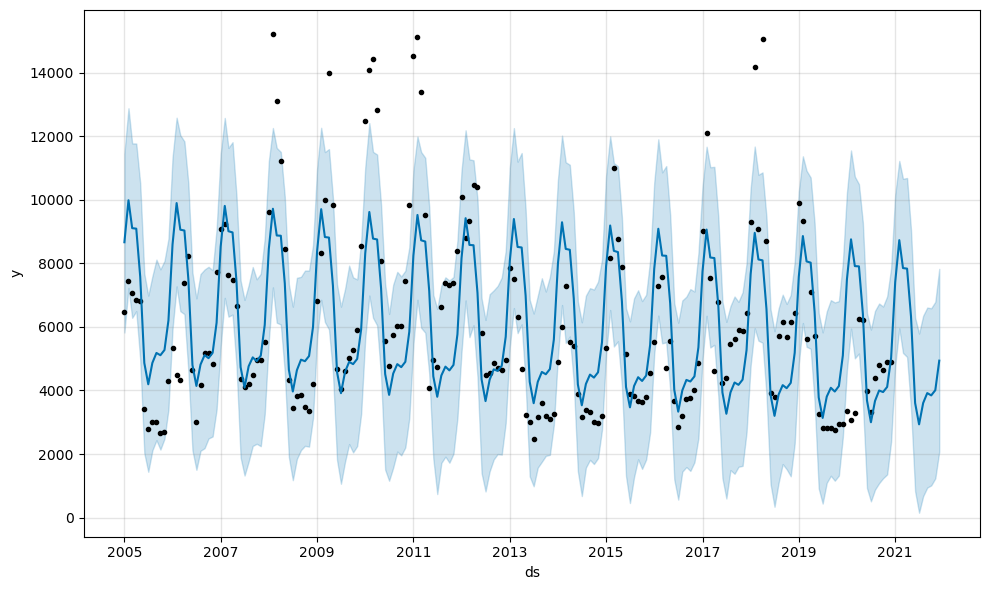

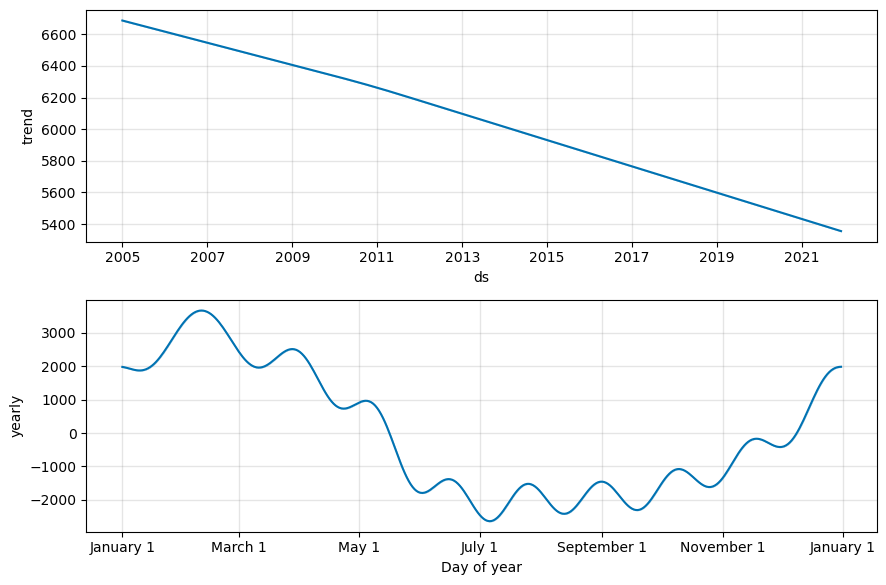

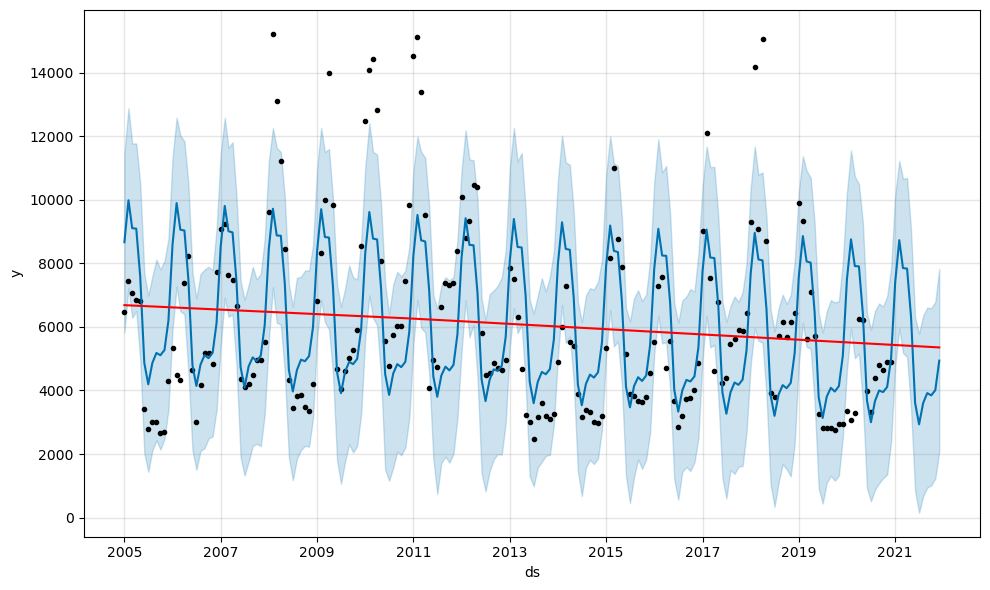

In [307]:
m = Prophet()
m.fit(df_raw)

if freq == "D":
    future = m.make_future_dataframe(periods=365, freq=freq)
elif freq ==  "M" or freq ==  "MS":
    future = m.make_future_dataframe(periods=12, freq=freq)

forecast = m.predict(future)



fig = m.plot(forecast)
plt.show()

fig2 = m.plot_components(forecast)
plt.show()

from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.show()

## cross_validation

In [308]:
# evaluation_model = cross_validation(m, initial='730 days', period='180 days', horizon = '30 days')
# evaluation_metrix = performance_metrics(evaluation_model)
# evaluation_metrix.head(5)

## Parameter - holiday

In [309]:
# # 휴일 생성
# import holidays

# # 필요한 날짜만큼 생성
# date_list = pd.date_range(f'{train[0]}-01-01', f'{test[1]}-12-31')

# # 한국 휴일 객체 생성
# kr_holidays = holidays.KR()

# # generate holiday table
# holiday = pd.DataFrame(columns=['ds','holiday'])
# holiday['ds'] = sorted(date_list)
# holiday['holiday'] = holiday.date.apply(lambda x: kr_holidays.get(x) if x in kr_holidays else 'non-holiday')
# holiday.head()

## Parameter Search - Grid

In [310]:
if params_search == True:
    from sklearn.model_selection import ParameterGrid
    # params_grid = {
    #             'seasonality_mode':('multiplicative','additive'),
    #             'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
    #             'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
    #             'n_changepoints' : [100,150,200]
    #             }
    
    params_grid = {
                'seasonality_mode':('multiplicative','additive'),
                'changepoint_prior_scale':[0.5, 1, 3, 5],
                'holidays_prior_scale':[0.2,0.3,0.4],
                'n_changepoints' : [100,150,200]
                }   
    
    grid = ParameterGrid(params_grid)
    cnt = 0
    for p in grid:
        cnt = cnt+1

    print('Total Possible Models',cnt)

Total Possible Models 72


In [311]:
params_search = True
if params_search == True:

    model_parameters = pd.DataFrame(columns=["MAE", "Parameters"])

    for p in grid:
        LOL = pd.DataFrame()
        print(p)
        #    random.seed(0)

        search_model = Prophet(
            changepoint_prior_scale=p["changepoint_prior_scale"],
            holidays_prior_scale=p["holidays_prior_scale"],
            n_changepoints=p["n_changepoints"],
            seasonality_mode=p["seasonality_mode"],
            daily_seasonality=True,
            yearly_seasonality=True,
            # holidays=holiday,
            interval_width=0.95,
        )

        search_model.fit(train)

        if freq == "D":
            periods = (test_year[1] - test_year[0] + 1) * 365
            future = search_model.make_future_dataframe(periods=periods, freq=freq)
        elif freq == "M" or freq == "MS":
            periods = (test_year[1] - test_year[0] + 1) * 12
            future = search_model.make_future_dataframe(
                periods=periods, freq=freq
            )

        search_forecast = search_model.predict(future)

        LOL = search_forecast[["ds", "yhat"]]
        y_true = test[y].values
        y_pred = LOL["yhat"][: len(y_true)].values
        mae = mean_absolute_error(y_true, y_pred)
        print("Mean Absolute Error: %.3f" % mae)
        model_parameters = model_parameters.append(
            {"MAE": mae, "Parameters": p}, ignore_index=True
        )

01:34:32 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


01:34:33 - cmdstanpy - INFO - Chain [1] done processing
01:34:33 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.161
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


01:34:33 - cmdstanpy - INFO - Chain [1] done processing
01:34:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.175
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


01:34:34 - cmdstanpy - INFO - Chain [1] done processing
01:34:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.155
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


01:34:34 - cmdstanpy - INFO - Chain [1] done processing
01:34:35 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.177
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


01:34:35 - cmdstanpy - INFO - Chain [1] done processing
01:34:35 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.155
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


01:34:36 - cmdstanpy - INFO - Chain [1] done processing
01:34:36 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.177
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


01:34:36 - cmdstanpy - INFO - Chain [1] done processing
01:34:37 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.161
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


01:34:37 - cmdstanpy - INFO - Chain [1] done processing
01:34:37 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.175
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


01:34:37 - cmdstanpy - INFO - Chain [1] done processing
01:34:38 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.155
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


01:34:38 - cmdstanpy - INFO - Chain [1] done processing
01:34:38 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.177
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


01:34:38 - cmdstanpy - INFO - Chain [1] done processing
01:34:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.155
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


01:34:39 - cmdstanpy - INFO - Chain [1] done processing
01:34:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.177
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


01:34:39 - cmdstanpy - INFO - Chain [1] done processing
01:34:40 - cmdstanpy - INFO - Chain [1] start processing
01:34:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.161
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


01:34:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.175
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


01:34:41 - cmdstanpy - INFO - Chain [1] done processing
01:34:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.155
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


01:34:41 - cmdstanpy - INFO - Chain [1] done processing
01:34:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.177
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


01:34:42 - cmdstanpy - INFO - Chain [1] done processing
01:34:42 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.155
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


01:34:42 - cmdstanpy - INFO - Chain [1] done processing
01:34:42 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.177
{'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


01:34:43 - cmdstanpy - INFO - Chain [1] done processing
01:34:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.161
{'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


01:34:43 - cmdstanpy - INFO - Chain [1] done processing
01:34:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.153
{'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


01:34:44 - cmdstanpy - INFO - Chain [1] done processing
01:34:45 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.163
{'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


01:34:45 - cmdstanpy - INFO - Chain [1] done processing
01:34:45 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.153
{'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


01:34:46 - cmdstanpy - INFO - Chain [1] done processing
01:34:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.163
{'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


01:34:46 - cmdstanpy - INFO - Chain [1] done processing
01:34:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.153
{'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


01:34:47 - cmdstanpy - INFO - Chain [1] done processing
01:34:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.161
{'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


01:34:48 - cmdstanpy - INFO - Chain [1] done processing
01:34:48 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.153
{'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


01:34:48 - cmdstanpy - INFO - Chain [1] done processing
01:34:49 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.163
{'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


01:34:49 - cmdstanpy - INFO - Chain [1] done processing
01:34:49 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.153
{'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


01:34:50 - cmdstanpy - INFO - Chain [1] done processing
01:34:50 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.163
{'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


01:34:51 - cmdstanpy - INFO - Chain [1] done processing
01:34:51 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.153
{'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


01:34:51 - cmdstanpy - INFO - Chain [1] done processing
01:34:51 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.161
{'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


01:34:52 - cmdstanpy - INFO - Chain [1] done processing
01:34:52 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.153
{'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


01:34:52 - cmdstanpy - INFO - Chain [1] done processing
01:34:53 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.163
{'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


01:34:53 - cmdstanpy - INFO - Chain [1] done processing
01:34:53 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.153
{'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


01:34:54 - cmdstanpy - INFO - Chain [1] done processing
01:34:54 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.163
{'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


01:34:54 - cmdstanpy - INFO - Chain [1] done processing
01:34:55 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.153
{'changepoint_prior_scale': 3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


01:34:55 - cmdstanpy - INFO - Chain [1] done processing
01:34:55 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.165
{'changepoint_prior_scale': 3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


01:34:56 - cmdstanpy - INFO - Chain [1] done processing
01:34:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.152
{'changepoint_prior_scale': 3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


01:34:56 - cmdstanpy - INFO - Chain [1] done processing
01:34:57 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.167
{'changepoint_prior_scale': 3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


01:34:57 - cmdstanpy - INFO - Chain [1] done processing
01:34:57 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.154
{'changepoint_prior_scale': 3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


01:34:58 - cmdstanpy - INFO - Chain [1] done processing
01:34:58 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.167
{'changepoint_prior_scale': 3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


01:34:59 - cmdstanpy - INFO - Chain [1] done processing
01:34:59 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.154
{'changepoint_prior_scale': 3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


01:34:59 - cmdstanpy - INFO - Chain [1] done processing
01:34:59 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.165
{'changepoint_prior_scale': 3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


01:35:00 - cmdstanpy - INFO - Chain [1] done processing
01:35:00 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.152
{'changepoint_prior_scale': 3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


01:35:00 - cmdstanpy - INFO - Chain [1] done processing
01:35:01 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.167
{'changepoint_prior_scale': 3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


01:35:01 - cmdstanpy - INFO - Chain [1] done processing
01:35:01 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.154
{'changepoint_prior_scale': 3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


01:35:02 - cmdstanpy - INFO - Chain [1] done processing
01:35:02 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.167
{'changepoint_prior_scale': 3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


01:35:03 - cmdstanpy - INFO - Chain [1] done processing
01:35:03 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.154
{'changepoint_prior_scale': 3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


01:35:03 - cmdstanpy - INFO - Chain [1] done processing
01:35:04 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.165
{'changepoint_prior_scale': 3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


01:35:04 - cmdstanpy - INFO - Chain [1] done processing
01:35:04 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.152
{'changepoint_prior_scale': 3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


01:35:05 - cmdstanpy - INFO - Chain [1] done processing
01:35:05 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.167
{'changepoint_prior_scale': 3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


01:35:06 - cmdstanpy - INFO - Chain [1] done processing
01:35:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.154
{'changepoint_prior_scale': 3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


01:35:06 - cmdstanpy - INFO - Chain [1] done processing
01:35:07 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.167
{'changepoint_prior_scale': 3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


01:35:07 - cmdstanpy - INFO - Chain [1] done processing
01:35:07 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.154
{'changepoint_prior_scale': 5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


01:35:08 - cmdstanpy - INFO - Chain [1] done processing
01:35:08 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.165
{'changepoint_prior_scale': 5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


01:35:08 - cmdstanpy - INFO - Chain [1] done processing
01:35:08 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.159
{'changepoint_prior_scale': 5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


01:35:09 - cmdstanpy - INFO - Chain [1] done processing
01:35:09 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.161
{'changepoint_prior_scale': 5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


01:35:10 - cmdstanpy - INFO - Chain [1] done processing
01:35:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.152
{'changepoint_prior_scale': 5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


01:35:10 - cmdstanpy - INFO - Chain [1] done processing
01:35:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.161
{'changepoint_prior_scale': 5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


01:35:11 - cmdstanpy - INFO - Chain [1] done processing
01:35:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.152
{'changepoint_prior_scale': 5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


01:35:12 - cmdstanpy - INFO - Chain [1] done processing
01:35:12 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.165
{'changepoint_prior_scale': 5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


01:35:13 - cmdstanpy - INFO - Chain [1] done processing
01:35:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.159
{'changepoint_prior_scale': 5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


01:35:13 - cmdstanpy - INFO - Chain [1] done processing
01:35:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.161
{'changepoint_prior_scale': 5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


01:35:14 - cmdstanpy - INFO - Chain [1] done processing
01:35:14 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.152
{'changepoint_prior_scale': 5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


01:35:15 - cmdstanpy - INFO - Chain [1] done processing
01:35:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.161
{'changepoint_prior_scale': 5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


01:35:16 - cmdstanpy - INFO - Chain [1] done processing
01:35:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.152
{'changepoint_prior_scale': 5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


01:35:16 - cmdstanpy - INFO - Chain [1] done processing
01:35:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.165
{'changepoint_prior_scale': 5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


01:35:17 - cmdstanpy - INFO - Chain [1] done processing
01:35:17 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.159
{'changepoint_prior_scale': 5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


01:35:18 - cmdstanpy - INFO - Chain [1] done processing
01:35:18 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.161
{'changepoint_prior_scale': 5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


01:35:19 - cmdstanpy - INFO - Chain [1] done processing
01:35:19 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.152
{'changepoint_prior_scale': 5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


01:35:19 - cmdstanpy - INFO - Chain [1] done processing
01:35:19 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error: 0.161
{'changepoint_prior_scale': 5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


01:35:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.152


## valid - cv (위치 수정 요망)

In [312]:
# if freq == "D":
#     evaluation_model = cross_validation(search_model, initial='730 days', period='180 days', horizon = '30 days')
#     evaluation_metrix = performance_metrics(evaluation_model)
#     display(evaluation_metrix.sort_values('mae').head(5))

# elif freq ==  "M" or freq ==  "MS":
#     cutoffs = pd.date_range(start=f'{train_year[0]+4}-01-01', end=f'{train_year[1]-1}-12-01', freq='6M')
#     # evaluation_model = cross_validation(model=search_model, initial='730 days', period='180 days', horizon = '90 days')
#     evaluation_model = cross_validation(model=search_model, cutoffs=cutoffs, horizon='365 days')
#     evaluation_metrix = performance_metrics(evaluation_model)
#     display(evaluation_metrix.sort_values('mae').head(5))

## Parameters

In [313]:
if params_search == True:
    parameters = model_parameters.sort_values(by=['MAE'])
    parameters = parameters.reset_index(drop=True)
    display(parameters.head())

    params = dict(parameters['Parameters'][0])
else:
    params = {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100,'seasonality_mode': 'additive'}

,MAE,Parameters
0,0.152162,"{'changepoint_prior_scale': 5, 'holidays_prior..."
1,0.152162,"{'changepoint_prior_scale': 5, 'holidays_prior..."
2,0.152162,"{'changepoint_prior_scale': 5, 'holidays_prior..."
3,0.152162,"{'changepoint_prior_scale': 5, 'holidays_prior..."
4,0.152162,"{'changepoint_prior_scale': 5, 'holidays_prior..."


## final_model

In [314]:
if freq == "D":
    start_date = pd.to_datetime(f'{train_year[0]}-01-01')
    end_date = pd.to_datetime(f'{test_year[1]}-12-31')
    dates = pd.date_range(start_date,end_date,freq=freq)
    dates = pd.DataFrame(dates)
    dates = dates.rename(columns={0 : 'ds'})
    display(dates)
    
    df['ds'] = pd.to_datetime(df['ds'])
    display(df['ds'])
    
    df = pd.merge(dates, df, how='outer', on='ds')
    display(df)
    
elif freq ==  "M" or freq ==  "MS":
    pass

## 학습

In [315]:
final_model = Prophet(
    # holidays=holiday,
    changepoint_prior_scale=params["changepoint_prior_scale"],
    holidays_prior_scale=params["holidays_prior_scale"],
    n_changepoints=params["n_changepoints"],
    seasonality_mode=params["seasonality_mode"],
    weekly_seasonality=True,
    daily_seasonality=True,
    yearly_seasonality=True,
    interval_width=0.95,
)
final_model.fit(train)

if freq == "D":
    periods = (test_year[1] - test_year[0] + 1) * 365
    future = final_model.make_future_dataframe(periods=periods, freq=freq)
elif freq ==  "M" or freq ==  "MS":
    periods = (test_year[1] - test_year[0] + 1) * 12
    future = final_model.make_future_dataframe(periods=periods, freq=freq) # https://github.com/facebook/prophet/issues/1281

01:35:20 - cmdstanpy - INFO - Chain [1] start processing
01:35:21 - cmdstanpy - INFO - Chain [1] done processing


## 예측

,ds,yhat,yhat_lower,yhat_upper
167,2018-12-01,8.949999,8.756636,9.145411
168,2019-01-01,9.400192,9.198042,9.601498
169,2019-02-01,9.548124,9.282832,9.811951
170,2019-03-01,9.539926,9.156534,9.958752
171,2019-04-01,9.490476,8.916046,10.076378
172,2019-05-01,9.074173,8.280379,9.841824
173,2019-06-01,8.714554,7.690219,9.714773
174,2019-07-01,8.620358,7.380152,9.794477
175,2019-08-01,8.852322,7.315325,10.315650
176,2019-09-01,8.967409,7.095934,10.698475


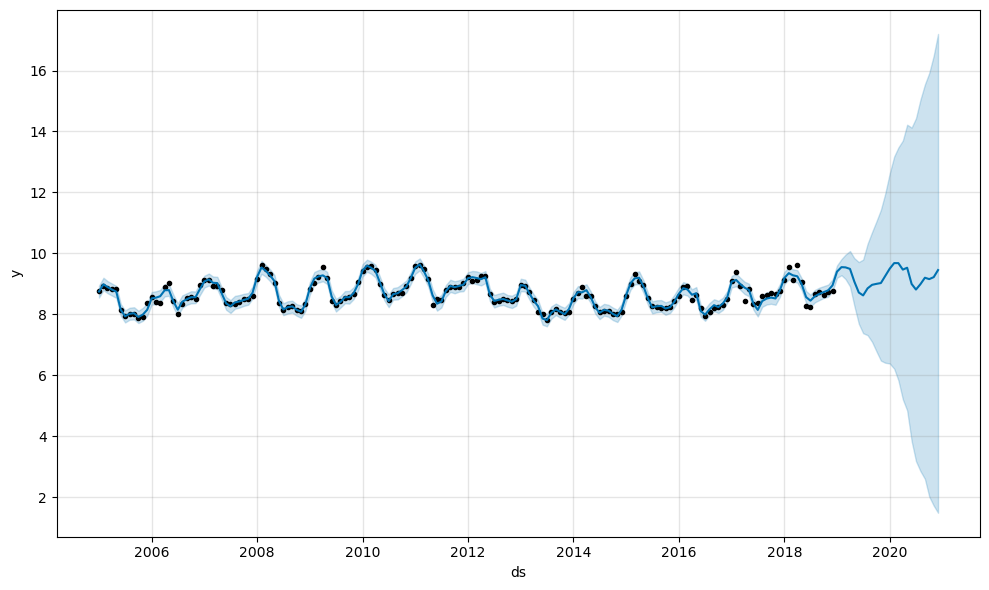

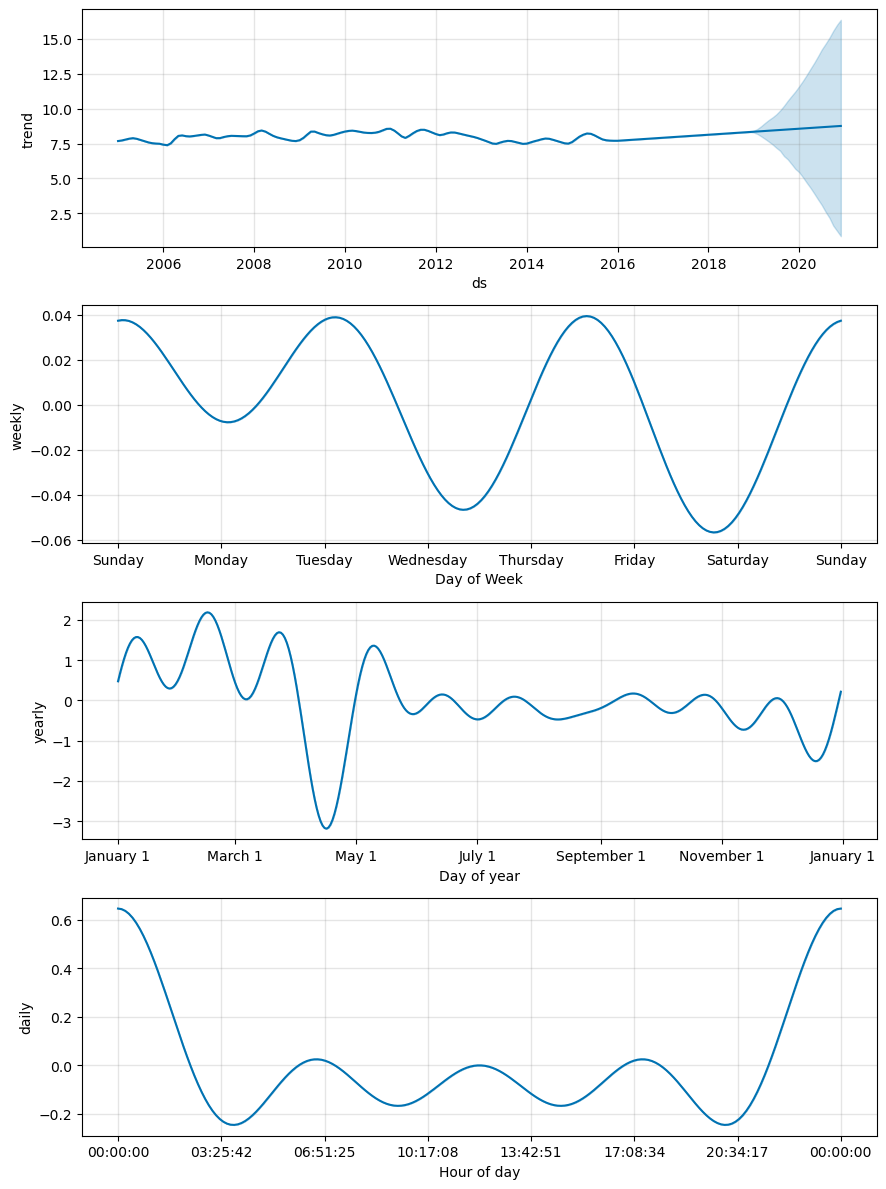

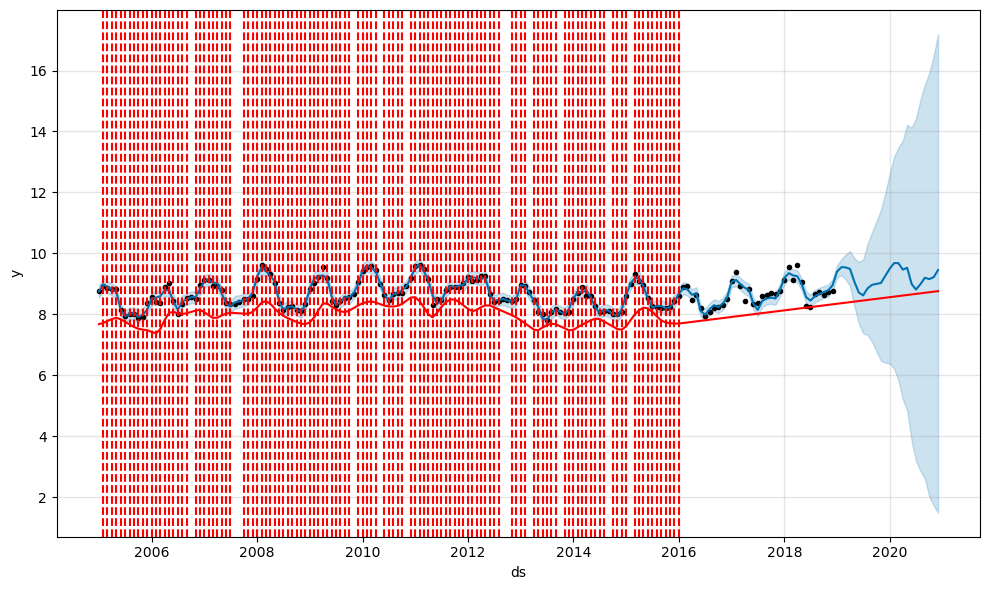

In [316]:
forecast = final_model.predict(future)

# forecast_col_list = forecast.columns.values.tolist()
forecast_col_list = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']

display(forecast[forecast_col_list].tail(periods+1))

fig = final_model.plot(forecast)
plt.show()

fig2 = final_model.plot_components(forecast)
plt.show()

from prophet.plot import add_changepoints_to_plot
fig = final_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), final_model, forecast)
plt.show()

# 평가

## pre-processing

### Inverse Scaling - np.log() → np.expm1

In [330]:
df_out = df_inp.copy()
forecast_copy = forecast.copy()

for i in logsca_list:
    df_out[i] = np.expm1(df_out[i])

f = forecast_col_list.copy()
try:
    f.remove("ds")
except:
    pass
for i in f:
    forecast_copy[i] = np.expm1(forecast_copy[i])
    
display(df_out[["ds"]+logsca_list])
display(forecast_copy[forecast_col_list])

,ds,y
0,2005-01,6466.292621
1,2005-02,7435.426577
2,2005-03,7080.545223
3,2005-04,6833.099024
4,2005-05,6802.346901
...,...,...
187,2020-08,4382.076468
188,2020-09,4789.924308
189,2020-10,4649.754234
190,2020-11,4888.213905


,ds,yhat,yhat_lower,yhat_upper
0,2005-01-01,6291.253678,5158.753905,7.603420e+03
1,2005-02-01,7974.599923,6588.297783,9.896890e+03
2,2005-03-01,7293.402027,5967.355056,8.865155e+03
3,2005-04-01,6706.799347,5510.328447,8.171511e+03
4,2005-05-01,6257.202869,5105.990234,7.549997e+03
...,...,...,...,...
187,2020-08-01,8010.429886,16.377011,3.408136e+06
188,2020-09-01,9897.909269,12.442309,5.634577e+06
189,2020-10-01,9459.094560,6.527368,8.190478e+06
190,2020-11-01,10093.487083,4.590864,1.450001e+07


### datetime

In [336]:
df_out['ds'] = pd.to_datetime(df_out['ds'])
df_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ds                       192 non-null    datetime64[ns]
 1   y                        192 non-null    float64       
 2   KRW_USD_EXR              192 non-null    float64       
 3   Annual_Call_Rate         192 non-null    float64       
 4   item_PPI                 192 non-null    float64       
 5   item_CPI                 192 non-null    float64       
 6   Food_Price_Index         192 non-null    float64       
 7   Cereals_Price_Index      192 non-null    float64       
 8   DayAvg_Temperature       192 non-null    float64       
 9   DayDiff_Temperature      192 non-null    float64       
 10  DayAvg_RelativeHumidity  192 non-null    float64       
 11  DaySum_Rainfall          192 non-null    float64       
 12  DayAvg_WindSpeed         192 non-nul

## 시각화

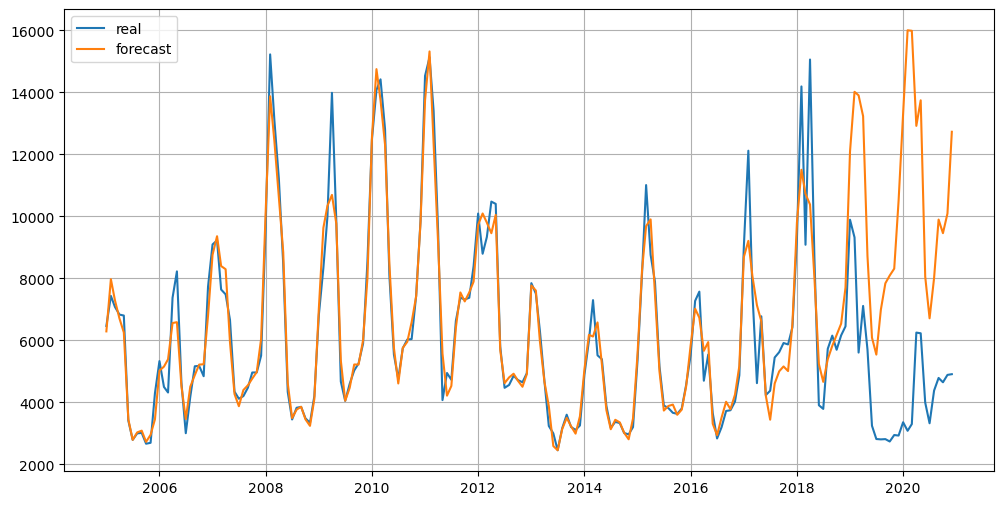

In [338]:
plt.figure(figsize=(12,6))
plt.plot(df_out['ds'], df_out[y], label='real')
plt.plot(forecast_copy['ds'], forecast_copy['yhat'], label='forecast')
plt.grid()
plt.legend()
plt.show()

In [347]:
con = pd.concat([df_out, forecast_copy], axis=1)
con = con.dropna(axis=0)
df_out = con[df_out.columns]
forecast_copy = con[forecast_copy.columns]

In [353]:
y_true= df_out[y].values
y_pred = forecast_copy['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('Mean Absolute Error: %.3f' % mae)

Mean Absolute Error: 1143.065


In [323]:
# if freq == "D":
#     evaluation_model = cross_validation(final_model, initial='730 days', period='180 days', horizon = '30 days')
#     evaluation_metrix = performance_metrics(evaluation_model)
#     display(evaluation_metrix.sort_values('mae').head(5))

# elif freq ==  "M" or freq ==  "MS":
#     cutoffs = pd.date_range(start='2005-01-01', end='2017-12-01', freq='6M')[4:-2]
#     # evaluation_model = cross_validation(model=final_model, initial='730 days', period='180 days', horizon = '90 days')
#     evaluation_model = cross_validation(model=final_model, cutoffs=cutoffs, horizon='365 days')
#     evaluation_metrix = performance_metrics(evaluation_model)
#     display(evaluation_metrix.sort_values('mae').head(5))

  0%|          | 0/20 [00:00<?, ?it/s]

01:35:22 - cmdstanpy - INFO - Chain [1] start processing
01:35:34 - cmdstanpy - INFO - Chain [1] done processing
01:35:34 - cmdstanpy - INFO - Chain [1] start processing
01:35:51 - cmdstanpy - INFO - Chain [1] done processing
01:35:51 - cmdstanpy - INFO - Chain [1] start processing
01:36:13 - cmdstanpy - INFO - Chain [1] done processing
01:36:14 - cmdstanpy - INFO - Chain [1] start processing
01:36:26 - cmdstanpy - INFO - Chain [1] done processing
01:36:26 - cmdstanpy - INFO - Chain [1] start processing
01:36:48 - cmdstanpy - INFO - Chain [1] done processing
01:36:48 - cmdstanpy - INFO - Chain [1] start processing
01:37:24 - cmdstanpy - INFO - Chain [1] done processing
01:37:24 - cmdstanpy - INFO - Chain [1] start processing
01:38:06 - cmdstanpy - INFO - Chain [1] done processing
01:38:06 - cmdstanpy - INFO - Chain [1] start processing
01:38:55 - cmdstanpy - INFO - Chain [1] done processing
01:38:55 - cmdstanpy - INFO - Chain [1] start processing


KeyboardInterrupt: 

In [360]:
# 
report_file_name = fr"""{model_name}_{Product_eng}_{"{"}freq.{freq}; test.{test_year}; MAE.{mae:0.4f};{"}"}.csv"""
df_temp = pd.DataFrame()
df_temp["true"] = y_true
df_temp["pred"] = y_pred
df_temp.to_csv(f"{data_path}{report_file_name}.csv")
display(df_temp.head())

# report file
reportinfo_file_name = f"{report_file_name}_info.txt"
x = train.columns
f = open(f"{data_path}{reportinfo_file_name}",'w')
f.write(f"model_name : {model_name}")
f.write("\n")
f.write(f"Product: {Product_eng}")
f.write("\n")
f.write(f"freq : {freq}")
f.write("\n")
f.write(f"test : {test_year}")
f.write("\n")
f.write(f"train : {train_year}")
f.write("\n")
f.write(f"x : {x}")
f.write("\n")
f.write(f"params : {params}")
f.close()

,true,pred
0,6466.292621,6291.253678
1,7435.426577,7974.599923
2,7080.545223,7293.402027
3,6833.099024,6706.799347
4,6802.346901,6257.202869
